In [3]:
import pandas as pd

def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(), columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name','dup_cnt']].apply(lambda x: x[0]+'_'+str(x[1])
                                                                                             if x[1]>0 else x[0], axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

def get_human_dataset():
    #각 데이터 파일은 공백으로 분리되어 있음
    feature_name_df = pd.read_csv('/content/drive/MyDrive/독학/Python ML/data/human_activity/features.txt', sep=r'\s+', header=None, names=['column_index','column_name'])
    #중복된 피처명을 수정하는 get_new_feature_name_df() 이용, 신규 피처명 DataFrame 생성
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    #DataFrame에 피처명을 칼럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:,1].values.tolist()
    #학습/테스트 피처 데이터를 DataFrame으로 로딩, 칼럼명은 feature_name 적용
    X_train = pd.read_csv('/content/drive/MyDrive/독학/Python ML/data/human_activity/train/X_train.txt', sep=r'\s+', names=feature_name)
    X_test = pd.read_csv('/content/drive/MyDrive/독학/Python ML/data/human_activity/test/X_test.txt', sep=r'\s+', names=feature_name)
    #학습/테스트 레이블 데이터를 DataFrame으로 로딩, 칼럼명은 action으로 부여
    y_train = pd.read_csv('/content/drive/MyDrive/독학/Python ML/data/human_activity/train/y_train.txt', sep=r'\s+', header=None, names=['action'])
    y_test = pd.read_csv('/content/drive/MyDrive/독학/Python ML/data/human_activity/test/y_test.txt', sep=r'\s+', header=None, names=['action'])
    #로딩된 학습/테스트용 DataFrame을 모두 반환
    return X_train, X_test, y_train, y_test

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

#학습/테스트용 DataFrame 반환
X_train, X_test, y_train, y_test = get_human_dataset()

#랜덤 포레스트 학습/예측/평가
rf_clf = RandomForestClassifier(random_state=0, max_depth=8)
rf_clf.fit(X_train, y_train)
pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print(f'랜덤 포레스트 정확도: {accuracy:.4f}')

랜덤 포레스트 정확도: 0.9220


In [5]:
#랜덤 포레스트 하이퍼 파라미터 튜닝
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth':[8,16,24],
    'min_samples_leaf':[1,6,12],
    'min_samples_split':[2,8,16]
}

#RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(X_train, y_train)

print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print(f'최고 예측 정확도: {grid_cv.best_score_:.4f}')

최적 하이퍼 파라미터:
 {'max_depth': 16, 'min_samples_leaf': 6, 'min_samples_split': 16}
최고 예측 정확도: 0.9157


In [6]:
#추출된 최적 하이퍼 파라미터로 RandomForestClassifier 학습 후 테스트 데이터에서 예측 성능 측정
rf_clf1 = RandomForestClassifier(n_estimators=100, min_samples_leaf=6, max_depth=16, min_samples_split=16, random_state=0)
rf_clf1.fit(X_train, y_train)
pred = rf_clf1.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print(f'예측 정확도: {accuracy:.4f}')

예측 정확도: 0.9209


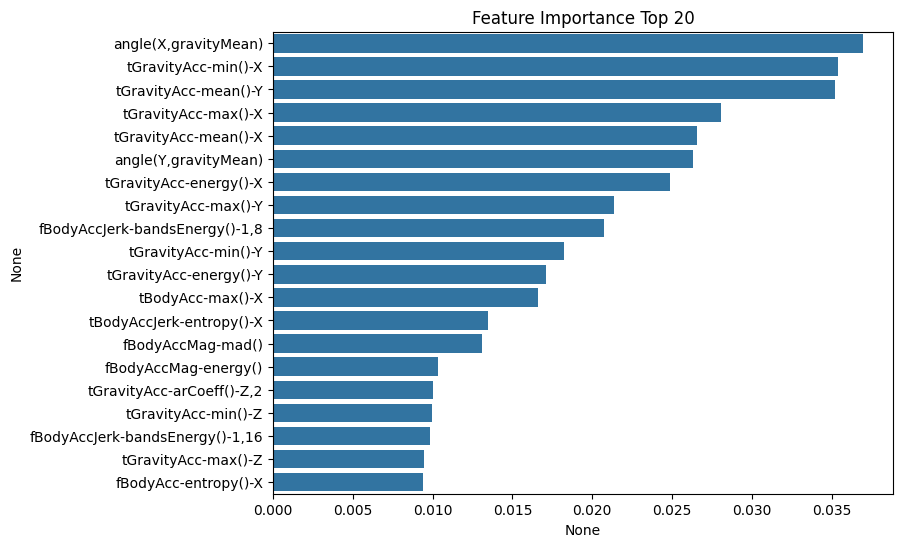

In [7]:
#RandomForestClassifier 알고리즘이 선택한 피처 중요도 시각화
import matplotlib.pyplot as plt
import seaborn as sns

ftr_importance_values = rf_clf1.feature_importances_
ftr_importance = pd.Series(ftr_importance_values, index=X_train.columns)
ftr_top20 = ftr_importance.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature Importance Top 20')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()